# Integrating PCA in Pipelines - Lab

## Introduction

In a previous section, you learned about how to use pipelines in scikit-learn to combine several supervised learning algorithms in a manageable pipeline. In this lesson, you will integrate PCA along with classifiers in the pipeline. 

## Objectives

In this lab you will: 

- Integrate PCA in scikit-learn pipelines 

## The Data Science Workflow

You will be following the data science workflow:

1. Initial data inspection, exploratory data analysis, and cleaning
2. Feature engineering and selection
3. Create a baseline model
4. Create a machine learning pipeline and compare results with the baseline model
5. Interpret the model and draw conclusions

##  Initial data inspection, exploratory data analysis, and cleaning

You'll use a dataset created by the Otto group, which was also used in a [Kaggle competition](https://www.kaggle.com/c/otto-group-product-classification-challenge/data). The description of the dataset is as follows:

The Otto Group is one of the world’s biggest e-commerce companies, with subsidiaries in more than 20 countries, including Crate & Barrel (USA), Otto.de (Germany) and 3 Suisses (France). They are selling millions of products worldwide every day, with several thousand products being added to their product line.

A consistent analysis of the performance of their products is crucial. However, due to their global infrastructure, many identical products get classified differently. Therefore, the quality of product analysis depends heavily on the ability to accurately cluster similar products. The better the classification, the more insights the Otto Group can generate about their product range.

In this lab, you'll use a dataset containing:
- A column `id`, which is an anonymous id unique to a product
- 93 columns `feat_1`, `feat_2`, ..., `feat_93`, which are the various features of a product
- a column `target` - the class of a product



The dataset is stored in the `'otto_group.csv'` file. Import this file into a DataFrame called `data`, and then: 

- Check for missing values 
- Check the distribution of columns 
- ... and any other things that come to your mind to explore the data 

In [1]:
%load_ext autoreload
%autoreload 2

import path
s_utils_path = "../../../../../../scjpnlib"
if path.Path(s_utils_path).isdir():
    with path.Path(s_utils_path):
        import utils as scjpnutils
        from utils.skl_transformers import LabelEncodingTransformer
else:
    raise FileNotFoundError("scjpnlib.utils import error: couldn't find path {s_utils_path}")

import pandas as pd
from IPython.core.display import HTML, Markdown



data = pd.read_csv("otto_group.csv")

scjpnutils.analyze_values(data, 'otto_group data');

There are no null/missing values.

In [2]:
# Your code here
X = data.drop(['id', 'target'], axis=1)

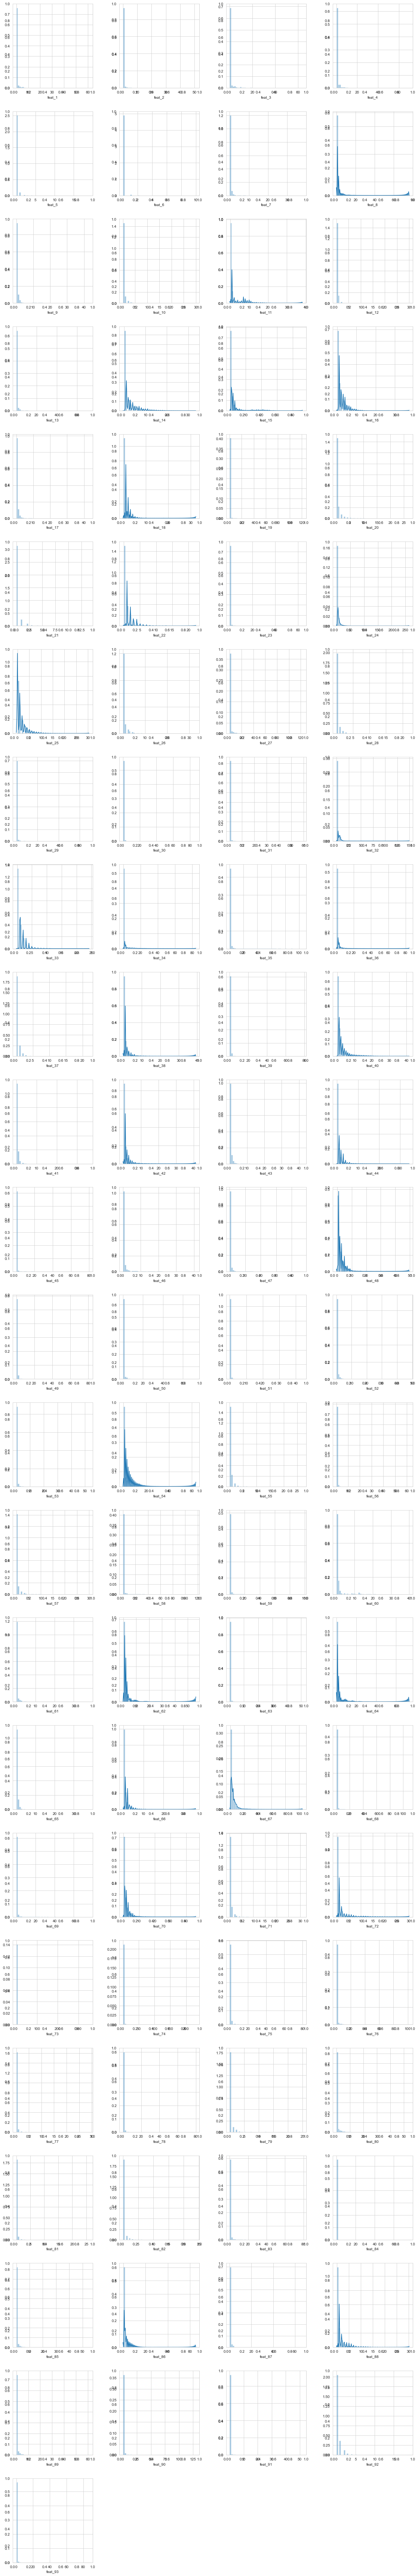

In [3]:
# Your code here
scjpnutils.histograms(X, consolidate=False);

Histograms/distributions indicate that ALL features are heavily dominated by the value 0.

In [4]:
y = data.target

let_labels = LabelEncodingTransformer(['target'])
y_encoded = let_labels.fit_transform(data[['target']])
classes = list(let_labels.labelencoder.classes_)

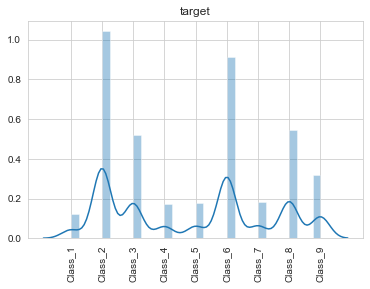

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
plt.title("target")
ax = sns.distplot(y_encoded[['target']], label='target')
plt.xticks(list(range(len(classes))), rotation=90)
ax.set_xticklabels(classes)
plt.show()

The distribution seems like it "wants" to be uniform.  It's not exactly normal.  But it's definitely not skewed.

If you look at all the histograms, you can tell that a lot of the data are zero-inflated, so most of the variables contain mostly zeros and then some higher values here and there. No normality, but for most machine learning techniques this is not an issue. 

Because there are so many zeroes, most values above zero will seem to be outliers. The safe decision for this data is to not delete any outliers and see what happens. With many 0s, sparse data is available and high values may be super informative. Moreover, without having any intuitive meaning for each of the features, we don't know if a value of ~260 is actually an outlier.

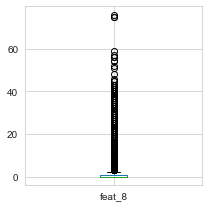

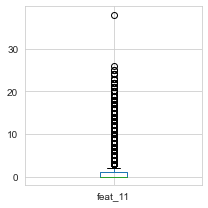

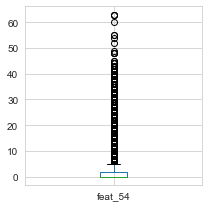

In [6]:
# since there are 93 features that all seem to follow this pattern, let's pick a few prominent examples from the histograms above
#   feat_8, feat_11, feat_54, for example
feats=['feat_8', 'feat_11', 'feat_54']

for feat in feats:
    scjpnutils.analyze_outliers_detailed(
        data, 
        "", 
        feat,
        suppress_replacement_strat_analysis=True
    );
    display(HTML("<p><br>"))

As a result of the dominance by 0, "typical" outlier analysis indicates that "good" values manifest as outliers.  Thus, without prior knowledge of the dominance by 0, we might draw invalid conclusions resulting from outliers-analysis.  The point: it's good to understand distributions prior to immediately jumping into outliers-analysis.

## Feature engineering and selection with PCA

Have a look at the correlation structure of your features using a [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

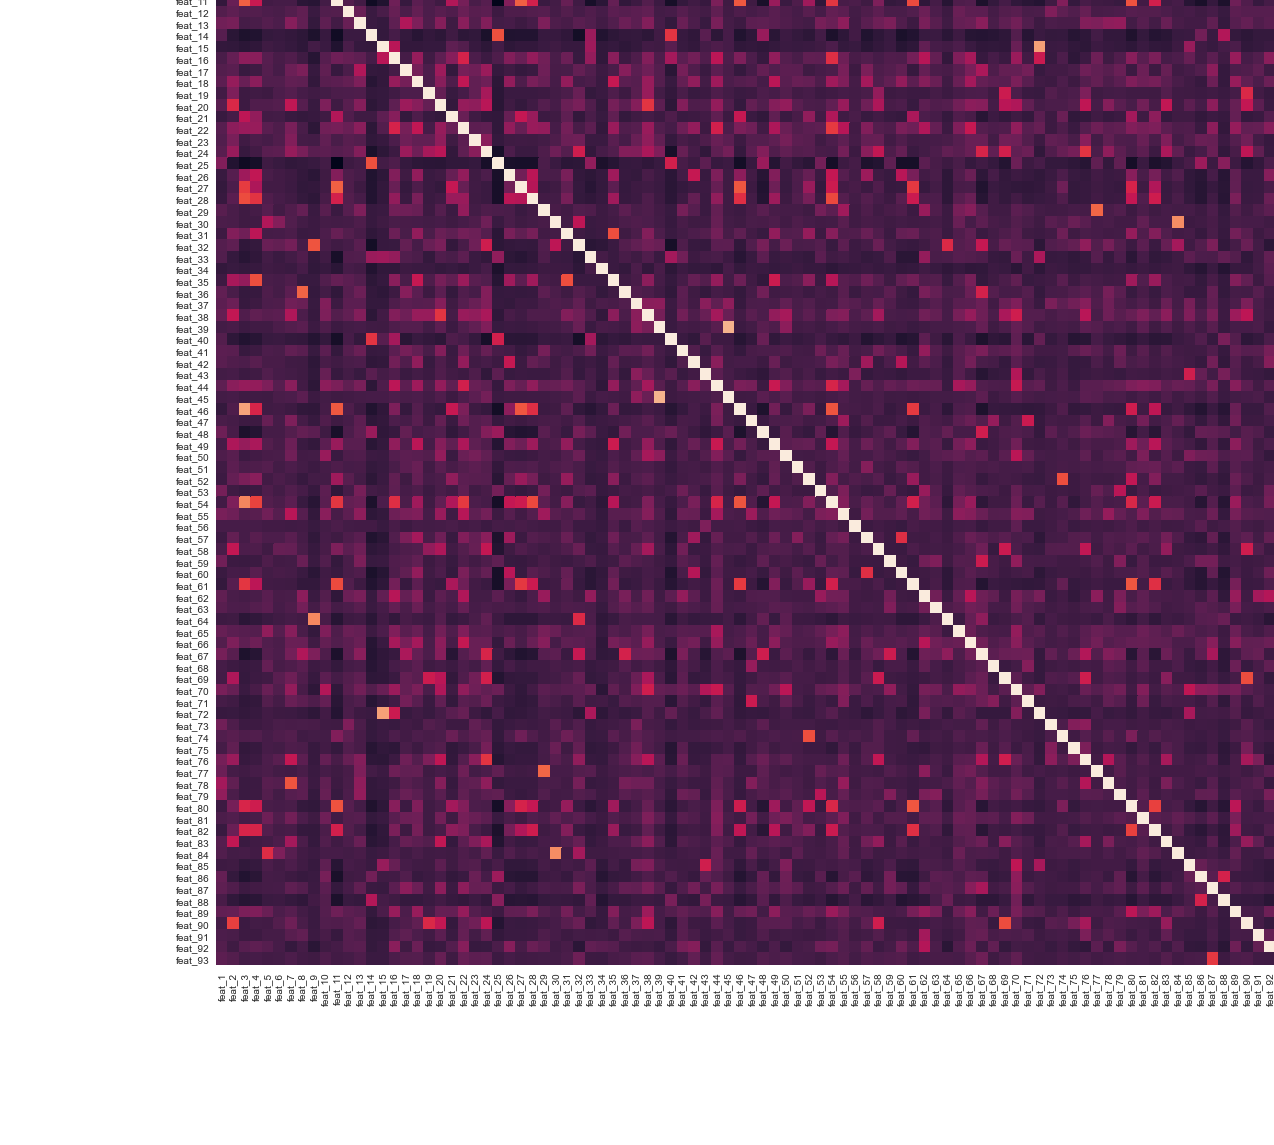

In [7]:
# Your code here
plt.figure(figsize=(24,20))
ax = sns.heatmap(X.corr())
plt.show()

Use PCA to select a number of features in a way that you still keep 80% of your explained variance.

In [8]:
# Your code here
from sklearn.decomposition import PCA
import numpy as np

ev_threshold = .80

for n_components__best in list(range(1, len(X.columns))):
    pca = PCA(n_components=n_components__best)
    pcs = pca.fit_transform(X)
    ev__best = np.sum(pca.explained_variance_ratio_)
    if ev__best >= ev_threshold:
        break

print(f"PCA best result:")
print(f"\tn_components: {n_components__best}")
print(f"\texplained variance: {ev__best}")

PCA best result:
	n_components: 27
	explained variance: 0.8003392557942834


## Create a train-test split with a test size of 40%

This is a relatively big training set, so you can assign 40% to the test set. Set the `random_state` to 42. 

In [9]:
# Your code here
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.4, random_state=42)

## Create a baseline model

Create your baseline model *in a pipeline setting*. In the pipeline: 

- Your first step will be to scale your features down to the number of features that ensure you keep just 80% of your explained variance (which we saw before)
- Your second step will be to build a basic logistic regression model 

Make sure to fit the model using the training set and test the result by obtaining the accuracy using the test set. Set the `random_state` to 123. 

In [10]:
# Your code here
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    steps=[
        ('pca', PCA(n_components=n_components__best, random_state=123)),
        ('logreg_clf', LogisticRegression(random_state=123))
    ]
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=27, random_state=123)),
                ('logreg_clf', LogisticRegression(random_state=123))])

In [11]:
# Your code here
from sklearn.metrics import accuracy_score

pred_test = pipeline.predict(X_test)
accuracy_test = accuracy_score(pred_test, y_test)
print(f"Accuracy (test): {accuracy_test}")

Accuracy (test): 0.7279411764705882


## Create a pipeline consisting of a linear SVM, a simple decision tree, and a simple random forest classifier

Repeat the above, but now create three different pipelines:
- One for a standard linear SVM
- One for a default decision tree
- One for a random forest classifier

In [12]:
# Your code here
# ⏰ This cell may take several minutes to run

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers = [
    svm.SVC(random_state=123), 
    DecisionTreeClassifier(random_state=123), 
    RandomForestClassifier(random_state=123)
]

for clf in classifiers:
    pipeline = Pipeline(
        steps=[
            ('pca', PCA(n_components=n_components__best, random_state=123)),
            ('clf', clf)
        ]
    )
    pipeline.fit(X_train, y_train)
    pred_test = pipeline.predict(X_test)
    accuracy_test = accuracy_score(pred_test, y_test)
    print(f"{clf.__class__.__name__} Accuracy (test): {accuracy_test}")

SVC Accuracy (test): 0.7536360698125404
DecisionTreeClassifier Accuracy (test): 0.671178086619263
RandomForestClassifier Accuracy (test): 0.7733516483516484


## Pipeline with grid search

Construct two pipelines with grid search:
- one for random forests - try to have around 40 different models
- one for the AdaBoost algorithm 

In [13]:
# Your code here 
# imports
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

gs_clf_paramsS = [
    (
        RandomForestClassifier(random_state=123),

        {
            'clf__n_estimators': [100],
            'clf__criterion': ['entropy', 'gini'], 
            'clf__max_depth': [5, 10, 25],
            'clf__min_samples_leaf':[0.05, 0.1, 1],  
            'clf__min_samples_split':[0.05 ,0.1, 1]
        }
    ),

    (
        AdaBoostClassifier(random_state=123),
        
        {
            'clf__n_estimators': [10, 25, 50, 75],
            'clf__learning_rate': [1.0, 0.5, 0.1]
        }
    ),

    # Level-up (Optional): SVM pipeline with grid search
    (
        svm.SVC(random_state=123),
        
        {
            'clf__C': [1, 10], 
            'clf__gamma': [0.001, 0.01], 
            'clf__kernel': ['rbf']
        }
    )
]

K = 3

for gs_clf_params in gs_clf_paramsS:
    clf = gs_clf_params[0]
    params = gs_clf_params[1]

    print(f"Optimizing {clf.__class__.__name__} Model via GridSearchCV")

    pipeline = Pipeline(
        steps=[
            ('pca', PCA(n_components=n_components__best, random_state=123)),
            ('clf', clf)
        ]
    )

    gs = GridSearchCV(
        estimator=pipeline, 
        param_grid=params, 
        scoring='accuracy', 
        cv=K,  
        return_train_score=True,
        verbose=2,
        n_jobs=-1
    )

    gs.fit(X_train, y_train)
    pred_test = gs.best_estimator_.predict(X_test)
    accuracy_test = accuracy_score(pred_test, y_test)

    print(f"Best Results:")
    print(f"\tparams: {gs.best_params_}")
    print(f"\ttraining accuracy: {gs.best_score_}")
    print(f"\ttesting accuracy: {accuracy_test}")

    # Use your grid search object along with .cv_results to get the full result overview
    print(f"\nFull Result Overview:\n{gs.cv_results_}\n\n\n")

Optimizing RandomForestClassifier Model via GridSearchCV
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  3.2min finished
Best Results:
	params: {'clf__criterion': 'gini', 'clf__max_depth': 25, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 0.05, 'clf__n_estimators': 100}
	training accuracy: 0.6742444461856226
	testing accuracy: 0.675016160310278

Full Result Overview:
{'mean_fit_time': array([14.81222582, 14.84040411,  1.28932079,  8.84760372,  9.17838931,
        0.99421175, 24.47993231, 22.2988801 ,  0.55354261, 16.88498489,
       17.69993909,  1.02023284, 10.19978102, 10.57857156,  0.67417733,
       27.77226432, 21.45523477,  0.58926177, 13.92862678, 15.12258617,
        0.54728699,  9.26021171,  8.85192474,  

## Note

Note that this solution is only one of many options. The results in the Random Forest and AdaBoost models show that there is a lot of improvement possible by tuning the hyperparameters further, so make sure to explore this yourself!

## Summary 

Great! You've gotten a lot of practice in using PCA in pipelines. What algorithm would you choose and why?